In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss, f1_score, matthews_corrcoef
from skopt import BayesSearchCV
from skopt.space import Real,  Integer
from sklearn.metrics import roc_auc_score
from scipy.stats import sem

import warnings
warnings.filterwarnings("ignore")

clinical_df = pd.read_excel(
    'PCI 2016-2022 final database.xlsx',sheet_name=0,nrows=7442)
survival_df = pd.read_excel(
    'PCI 2016-2022 final database.xlsx',sheet_name=1,nrows=7442)

clinical_df.columns = clinical_df.columns.str.replace("[", "(")
clinical_df.columns = clinical_df.columns.str.replace("]", ")")
survival_df.columns = survival_df.columns.str.replace("[", "(")
survival_df.columns = survival_df.columns.str.replace("]", ")")

print("Clinical data table")
display(clinical_df)
print("Survival data table")
display(survival_df)
print("In hospital death = ",survival_df['In-hospital death'].sum(),"patients")
clinical_df['In-hospital death']=survival_df['In-hospital death']
clinical_df.drop(clinical_df[clinical_df['In-hospital death'] >= 1].index, inplace = True)
survival_df.drop(survival_df[survival_df['In-hospital death'] >= 1].index, inplace = True)
clinical_df.drop('In-hospital death',axis=1,inplace=True)
print("Clinical data table after removal of in-hospital death")
display(clinical_df)
print("Survival data table after removal of in-hospital death")
display(survival_df)

# Analyze CV death or all cause death
CV_death=1

Clinical data table


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Avg.),Uric acid (mg/dL) (First),Uric acid (mg/dL) (Last),Uric acid (mg/dL) (Min.),Uric acid (mg/dL) (Max.),Uric acid (mg/dL) (Count)
0,667810842666812,422148281552015,306187964086387,1,39.756220,0,0,0,0,0,...,5.38,5.38,5.38,1,NaN,NaN,NaN,NaN,NaN,0
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7.28,7.28,7.28,1,NaN,NaN,NaN,NaN,NaN,0
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,7.64,7.64,7.64,1,NaN,NaN,NaN,NaN,NaN,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,7.87,5.42,11.10,14,NaN,NaN,NaN,NaN,NaN,0
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,5.81,5.81,5.81,1,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,6.98,6.98,6.98,1,6.30,6.30,6.30,6.30,6.30,1
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,4.24,4.24,4.24,1,4.96,4.96,4.96,4.96,4.96,1
7439,349936550502890,857771931036678,474160006718779,1,73.883396,0,0,0,0,0,...,9.92,9.92,9.92,1,NaN,NaN,NaN,NaN,NaN,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,5.53,4.99,5.82,3,6.02,6.02,6.02,6.02,6.02,1


Survival data table


,CNP,Nr. Ext.,In-hospital death,Cauza CV,Cauza non-CV,Days,Censor,Days CV,Censor CV,Survival status 6 months,...,Survival status CV 18 months,Survival status CV 2 years,Survival status CV 30 months,Survival status CV 3 years,Survival status CV 42 months,Survival status CV 4 years,Survival status CV 54 months,Survival status CV 5 years,Survival status CV 66 months,Survival status CV 6 years
0,306187964086387,667810842666812,1,1,0,0.000000,1,0.000000,1,1,...,1,1,1,1,1,1,1,1,1,1
1,573331431745647,472404851482187,0,0,1,57.561111,1,57.561111,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,365859696279897,901825898788254,0,0,0,452.589583,0,452.589583,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,972433808768011,709422392096649,0,0,0,1204.632639,0,1204.632639,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1
4,414721060707792,962864992156637,0,0,0,1582.573611,0,1582.573611,0,0,...,0,0,0,0,0,0,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,203293192306338,709952914258558,0,0,0,2317.666667,0,2317.666667,0,0,...,0,0,0,0,0,0,0,0,0,0
7438,574694259499259,739081227574047,0,0,0,2317.604167,0,2317.604167,0,0,...,0,0,0,0,0,0,0,0,0,0
7439,474160006718779,349936550502890,0,0,0,1950.474306,0,1950.474306,0,0,...,0,0,0,0,0,0,0,0,-1,-1
7440,848435220082227,622884827571002,0,0,0,2317.666667,0,2317.666667,0,0,...,0,0,0,0,0,0,0,0,0,0


In hospital death =  256 patients
Clinical data table after removal of in-hospital death


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Avg.),Uric acid (mg/dL) (First),Uric acid (mg/dL) (Last),Uric acid (mg/dL) (Min.),Uric acid (mg/dL) (Max.),Uric acid (mg/dL) (Count)
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,7.28,7.28,7.28,1,NaN,NaN,NaN,NaN,NaN,0
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,7.64,7.64,7.64,1,NaN,NaN,NaN,NaN,NaN,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,7.87,5.42,11.10,14,NaN,NaN,NaN,NaN,NaN,0
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,5.81,5.81,5.81,1,NaN,NaN,NaN,NaN,NaN,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,6.80,6.80,11.71,3,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,6.98,6.98,6.98,1,6.30,6.30,6.30,6.30,6.30,1
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,4.24,4.24,4.24,1,4.96,4.96,4.96,4.96,4.96,1
7439,349936550502890,857771931036678,474160006718779,1,73.883396,0,0,0,0,0,...,9.92,9.92,9.92,1,NaN,NaN,NaN,NaN,NaN,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,5.53,4.99,5.82,3,6.02,6.02,6.02,6.02,6.02,1


Survival data table after removal of in-hospital death


,CNP,Nr. Ext.,In-hospital death,Cauza CV,Cauza non-CV,Days,Censor,Days CV,Censor CV,Survival status 6 months,...,Survival status CV 18 months,Survival status CV 2 years,Survival status CV 30 months,Survival status CV 3 years,Survival status CV 42 months,Survival status CV 4 years,Survival status CV 54 months,Survival status CV 5 years,Survival status CV 66 months,Survival status CV 6 years
1,573331431745647,472404851482187,0,0,1,57.561111,1,57.561111,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,365859696279897,901825898788254,0,0,0,452.589583,0,452.589583,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,972433808768011,709422392096649,0,0,0,1204.632639,0,1204.632639,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1
4,414721060707792,962864992156637,0,0,0,1582.573611,0,1582.573611,0,0,...,0,0,0,0,0,0,-1,-1,-1,-1
5,132498628731573,916435896905189,0,1,0,1087.605556,1,1087.605556,1,0,...,0,0,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,203293192306338,709952914258558,0,0,0,2317.666667,0,2317.666667,0,0,...,0,0,0,0,0,0,0,0,0,0
7438,574694259499259,739081227574047,0,0,0,2317.604167,0,2317.604167,0,0,...,0,0,0,0,0,0,0,0,0,0
7439,474160006718779,349936550502890,0,0,0,1950.474306,0,1950.474306,0,0,...,0,0,0,0,0,0,0,0,-1,-1
7440,848435220082227,622884827571002,0,0,0,2317.666667,0,2317.666667,0,0,...,0,0,0,0,0,0,0,0,0,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Avg.),Uric acid (mg/dL) (First),Uric acid (mg/dL) (Last),Uric acid (mg/dL) (Min.),Uric acid (mg/dL) (Max.),Uric acid (mg/dL) (Count)
count,7.186000e+03,7.186000e+03,7.186000e+03,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,...,6994.000000,6994.000000,6994.000000,7186.000000,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000,7186.000000
mean,5.463473e+14,5.507207e+14,5.475875e+14,0.705260,64.171358,0.215558,0.027693,0.262037,0.068188,0.114111,...,8.046693,7.746897,9.279385,2.081826,6.346866,6.354053,6.342540,6.303766,6.390646,0.542583
std,2.607721e+14,2.575478e+14,2.631172e+14,0.455957,10.458343,0.411238,0.164102,0.439773,0.252086,0.317968,...,2.657440,2.313949,4.281141,2.421600,1.799818,1.811991,1.816939,1.806860,1.829825,0.648479
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.830000,0.540000,2.440000,0.000000,0.300000,0.300000,0.300000,0.300000,0.300000,0.000000
25%,3.206114e+14,3.282664e+14,3.173585e+14,0.000000,57.439255,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.470000,6.240000,6.930000,1.000000,5.082500,5.090000,5.070000,5.030000,5.100000,0.000000
50%,5.453212e+14,5.481059e+14,5.428970e+14,1.000000,64.900029,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.745000,7.490000,8.440000,1.000000,6.200000,6.200000,6.200000,6.160000,6.240000,0.000000
75%,7.726691e+14,7.748501e+14,7.831067e+14,1.000000,71.685897,0.000000,0.000000,1.000000,0.000000,0.000000,...,9.250000,8.930000,10.600000,2.000000,7.400000,7.400000,7.400000,7.367500,7.460000,1.000000
max,9.997399e+14,9.999622e+14,9.997525e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,113.690000,60.640000,159.120000,44.000000,16.480000,16.480000,16.480000,16.480000,16.480000,15.000000


<Axes: >

Alkaline phosphatase (U/L) (Max.)     7096
Alkaline phosphatase (U/L) (Min.)     7096
Alkaline phosphatase (U/L) (Last)     7096
Alkaline phosphatase (U/L) (First)    7096
Alkaline phosphatase (U/L) (Avg.)     7096
Iron (µg/dL) (Avg.)                   7000
Iron (µg/dL) (Last)                   7000
Iron (µg/dL) (First)                  7000
Iron (µg/dL) (Max.)                   7000
Iron (µg/dL) (Min.)                   7000
dtype: int64

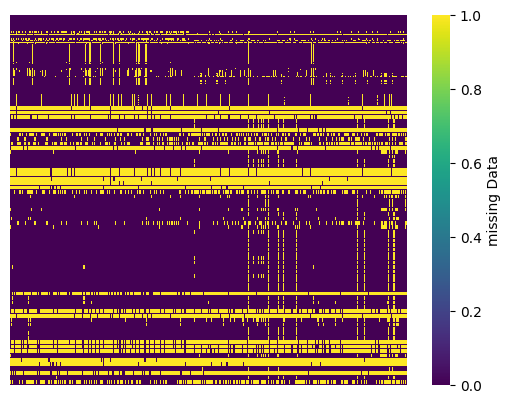

In [2]:
display(clinical_df.describe(include='all'))
display(sns.heatmap(clinical_df.isnull().transpose(),cmap="viridis", cbar_kws={"label": 'missing Data'}, xticklabels=False, yticklabels=False))
display(clinical_df.isnull().sum().sort_values(ascending=False).head(10))

### Removing columns with more than 40% missing data

,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Max.),Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count)
count,7.186000e+03,7.186000e+03,7.186000e+03,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,...,7123.000000,7186.000000,7186.000000,6994.000000,6994.000000,6994.000000,6994.000000,6994.000000,7186.000000,7186.000000
mean,5.463473e+14,5.507207e+14,5.475875e+14,0.705260,64.171358,0.215558,0.027693,0.262037,0.068188,0.114111,...,45.924647,3.241024,0.153771,8.442674,8.891763,8.046693,7.746897,9.279385,2.081826,0.542583
std,2.607721e+14,2.575478e+14,2.631172e+14,0.455957,10.458343,0.411238,0.164102,0.439773,0.252086,0.317968,...,27.591800,2.687805,0.580006,2.857145,4.053641,2.657440,2.313949,4.281141,2.421600,0.648479
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,0.000000,0.000000,2.060000,1.670000,0.830000,0.540000,2.440000,0.000000,0.000000
25%,3.206114e+14,3.282664e+14,3.173585e+14,0.000000,57.439255,0.000000,0.000000,0.000000,0.000000,0.000000,...,30.220000,2.000000,0.000000,6.690000,6.660000,6.470000,6.240000,6.930000,1.000000,0.000000
50%,5.453212e+14,5.481059e+14,5.428970e+14,1.000000,64.900029,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,3.000000,0.000000,8.055000,8.180000,7.745000,7.490000,8.440000,1.000000,0.000000
75%,7.726691e+14,7.748501e+14,7.831067e+14,1.000000,71.685897,0.000000,0.000000,1.000000,0.000000,0.000000,...,51.000000,4.000000,0.000000,9.740000,10.170000,9.250000,8.930000,10.600000,2.000000,1.000000
max,9.997399e+14,9.999622e+14,9.997525e+14,1.000000,100.094591,1.000000,1.000000,1.000000,1.000000,1.000000,...,357.000000,44.000000,14.000000,97.670000,159.120000,113.690000,60.640000,159.120000,44.000000,15.000000


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Max.),Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count)
1,472404851482187,245806663971812,573331431745647,1,63.428231,1,0,1,1,0,...,107.0,7,0,7.28,7.28,7.28,7.28,7.28,1,0
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,NaN,0,0,7.64,7.64,7.64,7.64,7.64,1,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,188.0,9,4,8.92,8.22,7.87,5.42,11.10,14,0
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,39.0,3,0,5.81,5.81,5.81,5.81,5.81,1,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,50.3,5,0,8.93,11.71,6.80,6.80,11.71,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,43.0,2,0,6.98,6.98,6.98,6.98,6.98,1,1
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,28.0,2,0,4.24,4.24,4.24,4.24,4.24,1,1
7439,349936550502890,857771931036678,474160006718779,1,73.883396,0,0,0,0,0,...,36.0,2,0,9.92,9.92,9.92,9.92,9.92,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,32.0,2,1,5.45,4.99,5.53,4.99,5.82,3,1


<Axes: >

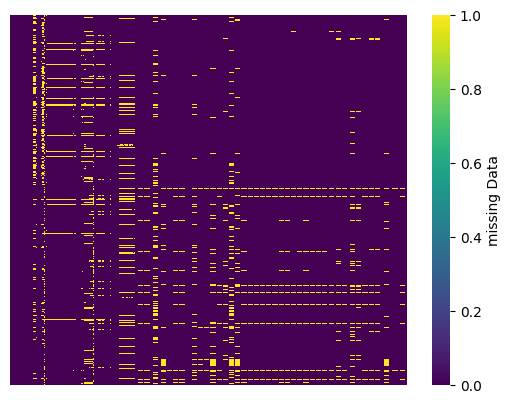

In [3]:
def drop_columns_with_missing_data(df, threshold_percent):
    threshold_count = len(df) * threshold_percent / 100.0

    df_cleaned = df.dropna(axis=1, thresh=(len(df) - threshold_count))
    
    return df_cleaned

threshold_percent = 40
clinical_df = drop_columns_with_missing_data(clinical_df, threshold_percent)
display(clinical_df.describe(include='all'))
display(clinical_df)
display(sns.heatmap(clinical_df.isnull(),cmap="viridis", cbar_kws={"label": 'missing Data'}, xticklabels=False, yticklabels=False))

### No missing data in survival data

,CNP,Nr. Ext.,In-hospital death,Cauza CV,Cauza non-CV,Days,Censor,Days CV,Censor CV,Survival status 6 months,...,Survival status CV 18 months,Survival status CV 2 years,Survival status CV 30 months,Survival status CV 3 years,Survival status CV 42 months,Survival status CV 4 years,Survival status CV 54 months,Survival status CV 5 years,Survival status CV 66 months,Survival status CV 6 years
count,7.186000e+03,7.186000e+03,7186.0,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,...,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000,7186.000000
mean,5.475875e+14,5.463473e+14,0.0,0.118703,0.054272,1449.984725,0.172975,1449.984725,0.118703,0.026997,...,-0.090454,-0.131088,-0.170749,-0.195937,-0.226969,-0.279015,-0.342332,-0.403562,-0.472307,-0.540217
std,2.631172e+14,2.607721e+14,0.0,0.323461,0.226570,776.162753,0.378252,776.162753,0.323461,0.162086,...,0.417302,0.473738,0.522492,0.555622,0.588076,0.621755,0.652799,0.673555,0.686989,0.691018
min,1.000373e+14,1.001593e+14,0.0,0.000000,0.000000,-0.416667,0.000000,-0.416667,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,3.173585e+14,3.206114e+14,0.0,0.000000,0.000000,740.885417,0.000000,740.885417,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,5.428970e+14,5.453212e+14,0.0,0.000000,0.000000,1519.092708,0.000000,1519.092708,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000
75%,7.831067e+14,7.726691e+14,0.0,0.000000,0.000000,2117.526736,0.000000,2117.526736,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.997525e+14,9.997399e+14,0.0,1.000000,1.000000,2737.666667,1.000000,2737.666667,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

CNP                             0
Survival status 54 months       0
Survival status CV 66 months    0
Survival status CV 5 years      0
Survival status CV 54 months    0
Survival status CV 4 years      0
Survival status CV 42 months    0
Survival status CV 3 years      0
Survival status CV 30 months    0
Survival status CV 2 years      0
dtype: int64

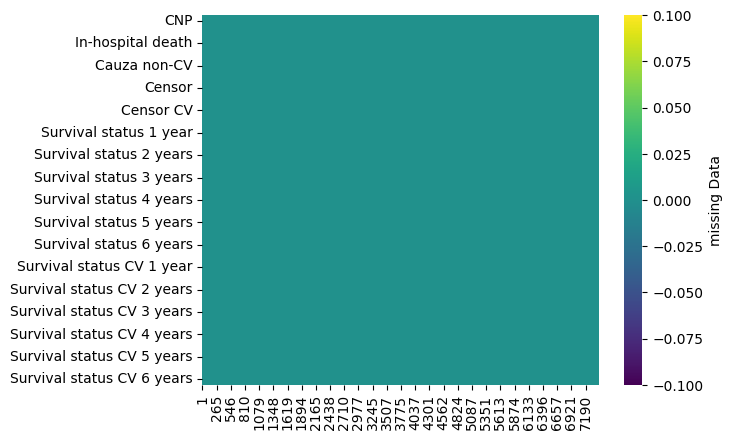

In [4]:
display(survival_df.describe(include='all'))
display(sns.heatmap(survival_df.isnull().transpose(),cmap="viridis", cbar_kws={"label": 'missing Data'}))
display(survival_df.isnull().sum().sort_values(ascending=False).head(10))

## Supporting functions

In [5]:
def bayesian_search(df):

    X    = df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y    = df['Outcome']

    search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(3, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'),
                 'reg_lambda': Real(1e-9, 100., 'uniform'),
                 'reg_alpha': Real(1e-9, 100., 'uniform'),
                 'n_estimators': Integer(50, 5000)
   }
    bayes_search = BayesSearchCV(estimator=xgb.XGBClassifier(eval_metric='auc'), verbose=1,search_spaces=search_spaces,n_points=5,n_jobs=10, cv=5, n_iter=150)

    bayes_search.fit(X,y)  
    best_params = bayes_search.best_params_
    print(best_params)
    return best_params

def train_model_with_bayesian_search(df,best_params):
    count_1 = df[df['Outcome'] == 1].shape[0]
    count_0 = df[df['Outcome'] == 0].shape[0]
    ratio = int(count_0 / count_1)
    unique_patients = df['CNP'].unique()
    f2345, f1 = train_test_split(unique_patients, test_size=0.20, random_state=12)
    f1_df = df[df['CNP'].isin(f1)]
    f2345_df = df[df['CNP'].isin(f2345)]
    unique_patients = f2345_df['CNP'].unique()

    f345, f2 = train_test_split(unique_patients, test_size=0.25, random_state=12)
    f2_df = df[df['CNP'].isin(f2)]
    f345_df = df[df['CNP'].isin(f345)]
    unique_patients = f345_df['CNP'].unique()

    f45, f3 = train_test_split(unique_patients, test_size=0.33, random_state=12)
    f3_df = df[df['CNP'].isin(f3)]
    f45_df = df[df['CNP'].isin(f45)]
    unique_patients = f45_df['CNP'].unique()

    f5, f4 = train_test_split(unique_patients, test_size=0.50, random_state=12)
    f4_df = df[df['CNP'].isin(f4)]
    f5_df = df[df['CNP'].isin(f5)]

    X_f1 = f1_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f1 = f1_df['Outcome']
    X_f2 = f2_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f2 = f2_df['Outcome']
    X_f3 = f3_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f3 = f3_df['Outcome']
    X_f4 = f4_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f4 = f4_df['Outcome']
    X_f5 = f5_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
    y_f5 = f5_df['Outcome']

    model = xgb.XGBClassifier(**best_params,scale_pos_weight=ratio)
    model.fit(X_f1, y_f1)
    model.fit(X_f2, y_f2)
    model.fit(X_f3, y_f3)
    model.fit(X_f4, y_f4)
    model.fit(X_f5, y_f5)

    return model

def save_model(model, file_path):
    try:
        joblib.dump(model, file_path)
        print(f"Model saved to {file_path}")
    except Exception as e:
        print(f"Error while saving the model: {e}")

In [6]:
def compute_bootstrapped_AUC_ROC_CI (y_true,y_pred):
    n_bootstraps = 1000
    rng_seed = 42  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        score = roc_auc_score(np.take(y_true,indices), np.take(y_pred,indices))
        bootstrapped_scores.append(score)        
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lowerML = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upperML = sorted_scores[int(0.95 * len(sorted_scores))]
    print("Confidence interval for the ML: [{:0.3f} - {:0.3}]".format(
        confidence_lowerML, confidence_upperML))
    return confidence_lowerML, confidence_upperML

def compute_bootstrapped_AUC_PR_CI(precision_values, recall_values, num_bootstraps=1000, ci_level=0.95):
    pr_curves = []
    for _ in range(num_bootstraps):
        idx = np.random.choice(len(precision_values), len(precision_values), replace=True)
        bootstrap_precision = np.array(precision_values)[idx]
        bootstrap_recall = np.array(recall_values)[idx]
        sorted_idx = np.argsort(bootstrap_recall)
        sorted_precision = bootstrap_precision[sorted_idx]
        sorted_recall = bootstrap_recall[sorted_idx]
        pr_curves.append((sorted_recall, sorted_precision))
    auc_scores = [auc(recall_curve, precision_curve) for recall_curve, precision_curve in pr_curves]
    auc_scores.sort()
    ci_lower = auc_scores[int((1 - ci_level) / 2 * num_bootstraps)]
    ci_upper = auc_scores[int((1 + ci_level) / 2 * num_bootstraps)] 
    return ci_lower, ci_upper

def calculate_youden_cutoff(true_positive_rates, false_positive_rates, thresholds):
    youden_values = true_positive_rates - false_positive_rates
    max_youden_index = np.argmax(youden_values)
    optimal_youden = thresholds[max_youden_index]
    return optimal_youden

def brier_skill_score(observed, forecast):
    climatology = np.mean(observed)
    bs = np.mean((forecast - observed)**2)
    bs_ref = np.mean((climatology - observed)**2)
    bss = 1 - (bs / bs_ref)
    return bss

In [7]:
import os
def append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                         No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        months,timeframe, auc_roc_train,upper_roc_train, lower_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation,
                        youden, matthews_corrcoef_train, matthews_corrcoef_validation, f1_score_train, f1_score_validation, brier_score_loss_train, brier_score_loss_validation,
                        brier_skill_score_train, brier_skill_score_validation):
    row=({
        'Timeframe': [timeframe],
        'Months': [months],

        "No_total_hospitalizations": [ No_total_hospitalizations],
        "No_unique_patients": [ No_unique_patients],
        "No_total_events": [ No_total_events],
        
        "No_training_hospitalizations": [ No_training_hospitalizations],
        "No_training_patients": [ No_training_patients],
        "No_training_events": [ No_training_events],

        "No_validation_hospitalizations": [ No_validation_hospitalizations],
        "No_validation_patients": [ No_validation_patients],
        "No_validation_events": [ No_validation_events],
           
        'auc_roc_train': [auc_roc_train],
        'lower_roc_train': [lower_roc_train],
        "upper_roc_train": [upper_roc_train],
        "auc_roc_validation": [auc_roc_validation],
        "lower_roc_validation": [ lower_roc_validation],
        "upper_roc_validation": [ upper_roc_validation],
        "auc_pr_train": [ auc_pr_train],
        "lower_pr_train": [ lower_pr_train],
        "upper_pr_train": [upper_pr_train],
        "auc_pr_validation": [ auc_pr_validation],
        "lower_pr_validation": [ lower_pr_validation],
        "upper_pr_validation": [ upper_pr_validation],
        "Youden cut-off": [youden],
        "MCC train": [matthews_corrcoef_train],
        "MCC validation": [matthews_corrcoef_validation],
        "F1 train": [ f1_score_train],
        "F1 validation": [ f1_score_validation],
        "BS train": [brier_score_loss_train],
        "BS validation": [brier_score_loss_validation],
        "BSS train": [brier_skill_score_train],
        "BSS validation": [brier_skill_score_validation],
    })
    dataframe = pd.DataFrame(row)
    csv_file_path='result.csv'
    if os.path.exists(csv_file_path):
        existing_data = pd.read_csv(csv_file_path)
        combined_data = pd.concat([existing_data, dataframe], ignore_index=True)
    else:
        combined_data = dataframe
    combined_data.to_csv(csv_file_path, index=False)
    
    

## Bayesian search of best hyperparameters on 6 years data

In [8]:
working_df_6y=clinical_df.copy()

if CV_death==0:
    working_df_6y['Outcome']=survival_df['Survival status 6 years']
else:
    working_df_6y['Outcome']=survival_df['Survival status CV 6 years']
working_df_6y.drop(working_df_6y[working_df_6y['Outcome'] <= -1].index, inplace = True)

unique_patients = working_df_6y['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df_6y[working_df_6y['CNP'].isin(train_patients)]

best_params=bayesian_search(training_testing_df)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates

In [9]:
import pickle
def save_to_file(variable, filename):
    with open(filename, 'wb') as file:
        pickle.dump(variable, file)

def load_from_file(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

save_to_file(best_params, 'best_params.pkl')
best_params = load_from_file('best_params.pkl')
print("Loaded data from file:", best_params)

Loaded data from file: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.7265132441940079), ('max_depth', 3), ('n_estimators', 3403), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('subsample', 1.0)])


## Survival at 6 months

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,0,0,7.64,7.64,7.64,7.64,7.64,1,0,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
6,277087804801688,986907769650377,841854219453947,0,68.064808,0,0,0,0,0,...,3,0,10.15,11.51,8.79,8.79,11.51,2,0,0
7,157877497192414,204398183505829,717689241032262,1,84.036800,0,0,0,0,0,...,5,0,8.33,9.29,6.98,6.98,9.29,5,3,0
8,403978471817611,199810100508644,989081233580590,1,71.086792,0,0,0,0,0,...,4,1,8.79,10.82,6.95,6.95,10.82,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,4.981000e+03,4.981000e+03,4.981000e+03,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,...,4981.000000,4981.000000,4844.000000,4844.000000,4844.000000,4844.000000,4844.000000,4981.000000,4981.000000,4981.000000
mean,5.473507e+14,5.500259e+14,5.478402e+14,0.699257,64.313233,0.216222,0.028107,0.263802,0.063040,0.115639,...,3.227866,0.161413,8.465175,8.921557,8.056633,7.777911,9.303594,2.065850,0.547280,0.020879
std,2.608201e+14,2.582612e+14,2.628243e+14,0.458627,10.357872,0.411708,0.165295,0.440738,0.243058,0.319824,...,2.619680,0.614782,2.740549,3.828151,2.368689,2.283002,4.075616,2.363222,0.641928,0.142995
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.060000,2.440000,2.220000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.229178e+14,3.256189e+14,3.183490e+14,0.000000,57.578132,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.720000,6.700000,6.490000,6.270000,6.950000,1.000000,0.000000,0.000000
50%,5.446422e+14,5.448103e+14,5.410968e+14,1.000000,65.066716,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,8.070000,8.200000,7.765000,7.510000,8.450000,1.000000,1.000000,0.000000
75%,7.731116e+14,7.736181e+14,7.832644e+14,1.000000,71.797123,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.760000,10.210000,9.240000,8.932500,10.620000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,94.851185,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,14.000000,86.980000,125.650000,62.330000,60.640000,125.650000,33.000000,15.000000,1.000000


Events in training dataset: 104
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.160000e+03,2.160000e+03,2.160000e+03,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,...,2160.000000,2160.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2160.000000,2160.000000,2160.000000
mean,5.447716e+14,5.531629e+14,5.475589e+14,0.718519,63.704541,0.214352,0.027315,0.258796,0.078704,0.107407,...,3.200463,0.133333,8.335838,8.728874,7.967796,7.663810,9.108228,2.038889,0.528241,0.020833
std,2.611693e+14,2.563598e+14,2.640048e+14,0.449826,10.621881,0.410467,0.163037,0.438075,0.269338,0.309702,...,2.638845,0.486787,2.422254,3.114618,2.245241,2.148232,3.370565,2.193799,0.631971,0.142859
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,1.960000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.140632e+14,3.375315e+14,3.126874e+14,0.000000,56.639634,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.600000,6.580000,6.400000,6.180000,6.850000,1.000000,0.000000,0.000000
50%,5.470203e+14,5.561854e+14,5.498323e+14,1.000000,64.457757,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,8.010000,8.100000,7.690000,7.440000,8.380000,1.000000,0.000000,0.000000
75%,7.733111e+14,7.781003e+14,7.817115e+14,1.000000,71.197970,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.650000,10.070000,9.250000,8.930000,10.450000,2.000000,1.000000,0.000000
max,9.997399e+14,9.990023e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 45
Model saved to 0.5y_model.pkl
Confidence interval for the ML: [0.863 - 0.913]
Confidence interval for the ML: [0.801 - 0.883]


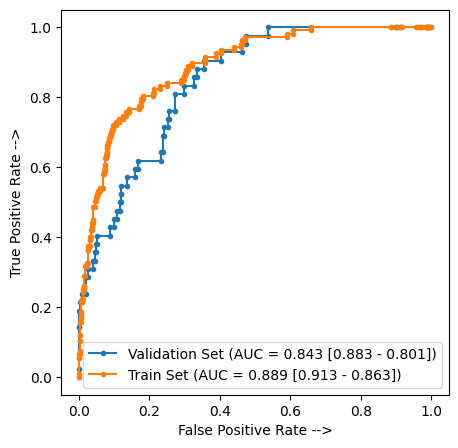

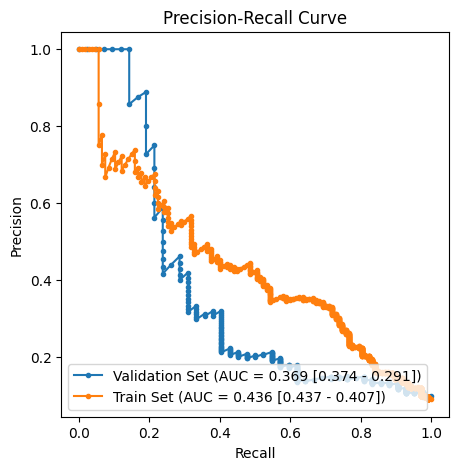

Youden cut-off =  0.11859256
BS train =  0.047415770220963716
BS validation =  0.04593966506735298
BSS train =  0.18371184726473133
BSS validation =  0.1277140328787506
F1 train =  0.4281842818428185
F1 validation =  0.28346456692913385
MCC train =  0.42028185696295867
MCC validation =  0.242464093296673


In [10]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 6 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 6 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "0.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('0.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        6,"0.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 1 year

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
2,901825898788254,332408110586314,365859696279897,1,55.718664,0,0,0,0,0,...,0,0,7.64,7.64,7.64,7.64,7.64,1,0,0
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
6,277087804801688,986907769650377,841854219453947,0,68.064808,0,0,0,0,0,...,3,0,10.15,11.51,8.79,8.79,11.51,2,0,0
7,157877497192414,204398183505829,717689241032262,1,84.036800,0,0,0,0,0,...,5,0,8.33,9.29,6.98,6.98,9.29,5,3,0
8,403978471817611,199810100508644,989081233580590,1,71.086792,0,0,0,0,0,...,4,1,8.79,10.82,6.95,6.95,10.82,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,4.651000e+03,4.651000e+03,4.651000e+03,4651.000000,4651.000000,4651.000000,4651.000000,4651.000000,4651.000000,4651.000000,...,4651.000000,4651.000000,4516.000000,4516.000000,4516.00000,4516.000000,4516.000000,4651.000000,4651.000000,4651.000000
mean,5.452743e+14,5.502088e+14,5.478862e+14,0.700280,64.250042,0.226403,0.029026,0.273705,0.062352,0.114814,...,3.187057,0.144700,8.434314,8.869885,8.04167,7.771488,9.235104,2.007525,0.541174,0.037626
std,2.608690e+14,2.590159e+14,2.625792e+14,0.458185,10.311657,0.418548,0.167897,0.445907,0.241820,0.318832,...,2.613335,0.607058,2.725270,3.751272,2.36594,2.278288,4.006369,2.314365,0.631922,0.190311
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.060000,2.440000,2.22000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.208901e+14,3.247811e+14,3.180669e+14,0.000000,57.678651,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.700000,6.670000,6.48000,6.277500,6.910000,1.000000,0.000000,0.000000
50%,5.415943e+14,5.452369e+14,5.427895e+14,1.000000,64.932719,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,8.030000,8.170000,7.75000,7.510000,8.400000,1.000000,1.000000,0.000000
75%,7.701075e+14,7.742812e+14,7.832162e+14,1.000000,71.679072,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.750000,10.160000,9.23000,8.930000,10.552500,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,14.000000,86.980000,125.650000,62.33000,60.640000,125.650000,33.000000,15.000000,1.000000


Events in training dataset: 175
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.032000e+03,2.032000e+03,2.032000e+03,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,...,2032.000000,2032.000000,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000,2032.000000,2032.000000,2032.000000
mean,5.453972e+14,5.532015e+14,5.473733e+14,0.722933,63.689299,0.222933,0.028051,0.263287,0.076772,0.107283,...,3.177165,0.120571,8.318311,8.713996,7.951356,7.657405,9.082898,2.020177,0.522146,0.032480
std,2.614856e+14,2.557462e+14,2.632370e+14,0.447660,10.599704,0.416316,0.165160,0.440525,0.266294,0.309549,...,2.671975,0.472514,2.427919,3.138307,2.254900,2.152393,3.391283,2.226488,0.632690,0.177316
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.149155e+14,3.400362e+14,3.126874e+14,0.000000,56.844898,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.560000,6.550000,6.380000,6.160000,6.810000,1.000000,0.000000,0.000000
50%,5.482373e+14,5.552496e+14,5.511831e+14,1.000000,64.503936,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.980000,8.080000,7.650000,7.430000,8.360000,1.000000,0.000000,0.000000
75%,7.750467e+14,7.769634e+14,7.806346e+14,1.000000,70.975180,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.630000,10.050000,9.230000,8.930000,10.370000,2.000000,1.000000,0.000000
max,9.997399e+14,9.990023e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 66
Model saved to 1y_model.pkl
Confidence interval for the ML: [0.863 - 0.907]
Confidence interval for the ML: [0.820 - 0.885]


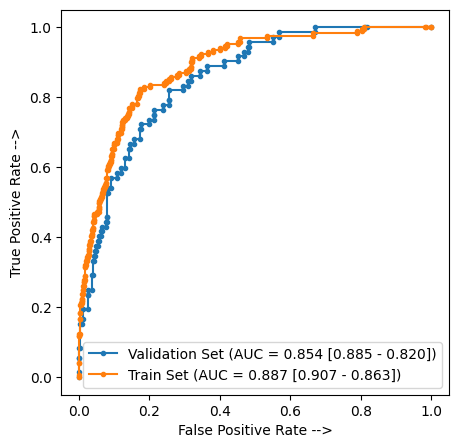

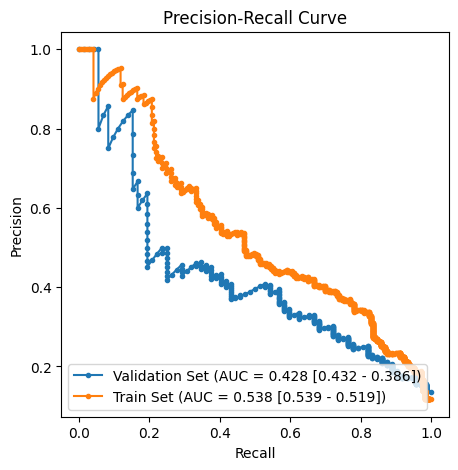

Youden cut-off =  0.11576651
BS train =  0.06736001282030771
BS validation =  0.07246307085304539
BSS train =  0.2365918050896163
BSS validation =  0.16203268597417175
F1 train =  0.47931034482758617
F1 validation =  0.42290748898678415
MCC train =  0.45210286916526826
MCC validation =  0.37060026537788626


In [11]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 1 year']
else:
    working_df['Outcome']=survival_df['Survival status CV 1 year']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "1y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('1y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        12,"1y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 1.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
6,277087804801688,986907769650377,841854219453947,0,68.064808,0,0,0,0,0,...,3,0,10.15,11.51,8.79,8.79,11.51,2,0,0
8,403978471817611,199810100508644,989081233580590,1,71.086792,0,0,0,0,0,...,4,1,8.79,10.82,6.95,6.95,10.82,4,1,0
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
11,293980352493624,575119259563355,218759704099816,0,49.614536,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,4.318000e+03,4.318000e+03,4.318000e+03,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,...,4318.000000,4318.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4318.000000,4318.000000,4318.000000
mean,5.453506e+14,5.512441e+14,5.464110e+14,0.698935,64.228898,0.239000,0.030107,0.284159,0.063224,0.114405,...,3.142195,0.138027,8.412228,8.834594,8.031312,7.770963,9.191319,1.961325,0.538212,0.053497
std,2.600867e+14,2.596596e+14,2.626879e+14,0.458774,10.305296,0.426522,0.170900,0.451065,0.243393,0.318339,...,2.620490,0.608361,2.746334,3.788955,2.377732,2.296326,4.044387,2.317539,0.625901,0.225048
min,1.001593e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,2.440000,2.440000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.222686e+14,3.247216e+14,3.174933e+14,0.000000,57.733226,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.690000,6.650000,6.480000,6.280000,6.900000,1.000000,0.000000,0.000000
50%,5.408300e+14,5.478955e+14,5.403606e+14,1.000000,64.894530,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,8.000000,8.130000,7.730000,7.500000,8.340000,1.000000,1.000000,0.000000
75%,7.701436e+14,7.762192e+14,7.819078e+14,1.000000,71.625963,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.680000,10.080000,9.202500,8.922500,10.470000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,14.000000,86.980000,125.650000,62.330000,60.640000,125.650000,33.000000,15.000000,1.000000


Events in training dataset: 231
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.888000e+03,1.888000e+03,1.888000e+03,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,...,1888.000000,1888.000000,1833.000000,1833.000000,1833.000000,1833.000000,1833.000000,1888.000000,1888.000000,1888.000000
mean,5.468109e+14,5.517821e+14,5.506548e+14,0.725106,63.600683,0.234640,0.030191,0.275953,0.075212,0.108051,...,3.150953,0.115996,8.298947,8.689858,7.933672,7.655041,9.036350,1.973517,0.517479,0.052436
std,2.613821e+14,2.545439e+14,2.636155e+14,0.446579,10.652705,0.423886,0.171157,0.447112,0.263803,0.310527,...,2.702918,0.474912,2.433760,3.105289,2.268795,2.154022,3.388144,2.217466,0.631039,0.222965
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.176244e+14,3.412656e+14,3.175057e+14,0.000000,56.639634,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.540000,6.550000,6.360000,6.160000,6.790000,1.000000,0.000000,0.000000
50%,5.491186e+14,5.514016e+14,5.576348e+14,1.000000,64.444298,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.950000,8.060000,7.630000,7.440000,8.300000,1.000000,0.000000,0.000000
75%,7.783750e+14,7.737532e+14,7.842641e+14,1.000000,70.890763,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,0.000000,9.630000,10.030000,9.190000,8.920000,10.360000,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 99
Model saved to 1.5y_model.pkl
Confidence interval for the ML: [0.864 - 0.903]
Confidence interval for the ML: [0.816 - 0.878]


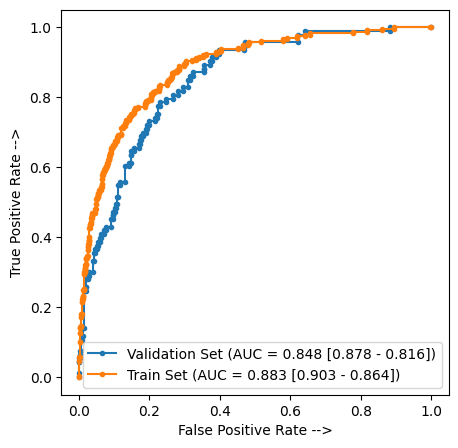

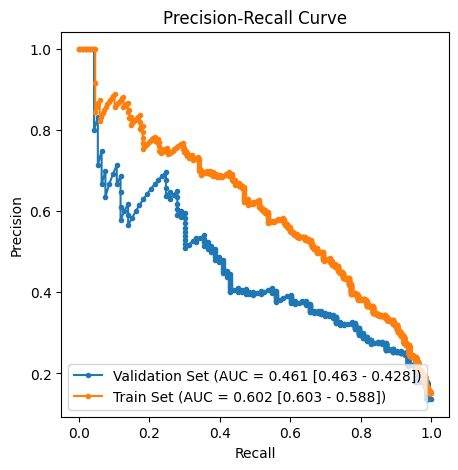

Youden cut-off =  0.15381622
BS train =  0.08247312871061963
BS validation =  0.08663933216640309
BSS train =  0.3030943954589682
BSS validation =  0.19965328946985927
F1 train =  0.5557251908396946
F1 validation =  0.4705882352941176
MCC train =  0.48974430895198473
MCC validation =  0.3928291943653008


In [12]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 18 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 18 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "1.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('1.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        18,"1.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 2 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
6,277087804801688,986907769650377,841854219453947,0,68.064808,0,0,0,0,0,...,3,0,10.15,11.51,8.79,8.79,11.51,2,0,0
8,403978471817611,199810100508644,989081233580590,1,71.086792,0,0,0,0,0,...,4,1,8.79,10.82,6.95,6.95,10.82,4,1,0
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
11,293980352493624,575119259563355,218759704099816,0,49.614536,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,4.073000e+03,4.073000e+03,4.073000e+03,4073.000000,4073.000000,4073.000000,4073.000000,4073.000000,4073.000000,4073.000000,...,4073.000000,4073.000000,3941.000000,3941.000000,3941.000000,3941.000000,3941.000000,4073.000000,4073.000000,4073.000000
mean,5.458184e+14,5.504598e+14,5.475638e+14,0.697275,64.206157,0.249202,0.030690,0.291431,0.064326,0.115640,...,3.103855,0.113184,8.388868,8.800223,8.011675,7.758353,9.155664,1.930273,0.534741,0.068745
std,2.604052e+14,2.594415e+14,2.625328e+14,0.459494,10.295857,0.432604,0.172497,0.454478,0.245363,0.319831,...,2.635198,0.579789,2.764123,3.811060,2.381916,2.302599,4.079749,2.327560,0.626709,0.253052
min,1.002216e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,2.440000,2.440000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.224247e+14,3.233754e+14,3.180770e+14,0.000000,57.796073,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.670000,6.630000,6.470000,6.270000,6.850000,1.000000,0.000000,0.000000
50%,5.409606e+14,5.457756e+14,5.407729e+14,1.000000,64.862932,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.960000,8.080000,7.720000,7.490000,8.290000,1.000000,1.000000,0.000000
75%,7.699798e+14,7.746590e+14,7.831679e+14,1.000000,71.510885,0.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.630000,10.000000,9.140000,8.900000,10.400000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,14.000000,86.980000,125.650000,62.330000,60.640000,125.650000,33.000000,15.000000,1.000000


Events in training dataset: 280
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.774000e+03,1.774000e+03,1.774000e+03,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,...,1774.000000,1774.000000,1721.000000,1721.000000,1721.000000,1721.000000,1721.000000,1774.000000,1774.000000,1774.000000
mean,5.454062e+14,5.527809e+14,5.545093e+14,0.723224,63.514164,0.244645,0.031567,0.285231,0.076663,0.110485,...,3.099775,0.084555,8.273823,8.649529,7.925793,7.652132,8.992185,1.929538,0.514092,0.065953
std,2.614988e+14,2.541282e+14,2.652135e+14,0.447531,10.625428,0.429998,0.174894,0.451652,0.266131,0.313581,...,2.699182,0.409501,2.454091,3.116588,2.292003,2.177091,3.412478,2.203442,0.632432,0.248269
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.162382e+14,3.420609e+14,3.180188e+14,0.000000,56.592976,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.520000,6.520000,6.340000,6.140000,6.710000,1.000000,0.000000,0.000000
50%,5.432562e+14,5.552496e+14,5.686679e+14,1.000000,64.303135,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.900000,8.010000,7.610000,7.430000,8.240000,1.000000,0.000000,0.000000
75%,7.781688e+14,7.750154e+14,7.904696e+14,1.000000,70.784656,0.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.570000,9.980000,9.190000,8.910000,10.280000,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 117
Model saved to 2y_model.pkl
Confidence interval for the ML: [0.874 - 0.91]
Confidence interval for the ML: [0.802 - 0.87]


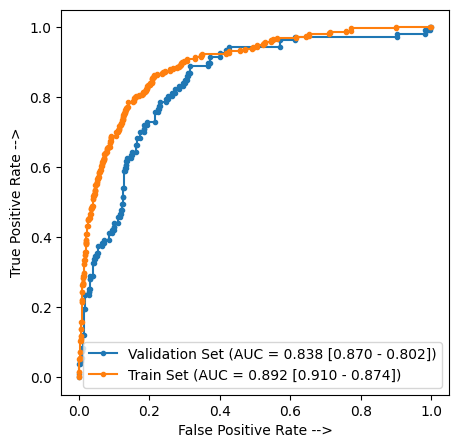

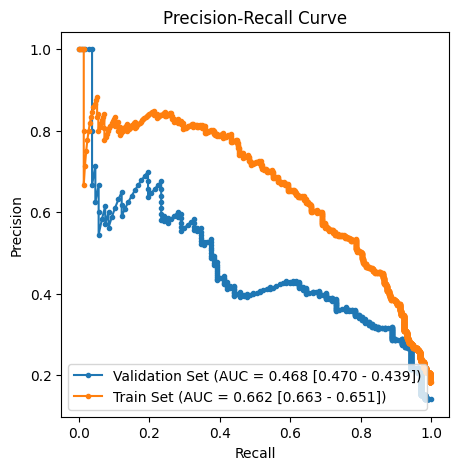

Youden cut-off =  0.12687665
BS train =  0.08967535446574061
BS validation =  0.09722828495115143
BSS train =  0.3578984853747301
BSS validation =  0.20243464277845813
F1 train =  0.591715976331361
F1 validation =  0.49240121580547114
MCC train =  0.5202061377851611
MCC validation =  0.4125400477376395


In [13]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 2 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 2 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "2y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('2y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        24,"2y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 2.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
13,228317629713460,811844987441852,770852312662831,0,59.609224,0,0,0,0,1,...,2,0,6.46,6.46,6.46,6.46,6.46,1,0,0
18,893924856245184,723038555585226,767890026091070,1,47.436636,0,0,0,0,1,...,2,0,6.68,6.81,6.55,6.55,6.81,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,3.826000e+03,3.826000e+03,3.826000e+03,3826.000000,3826.000000,3826.000000,3826.000000,3826.000000,3826.000000,3826.000000,...,3826.000000,3826.00000,3698.000000,3698.000000,3698.000000,3698.000000,3698.000000,3826.000000,3826.000000,3826.000000
mean,5.447259e+14,5.490651e+14,5.464247e+14,0.693675,64.160462,0.255097,0.032148,0.299791,0.064297,0.116048,...,3.030058,0.08024,8.354340,8.747399,7.998548,7.753813,9.086668,1.875849,0.522478,0.088604
std,2.602267e+14,2.596404e+14,2.632475e+14,0.461027,10.288573,0.435973,0.176417,0.458226,0.245313,0.320324,...,2.581662,0.50003,2.771287,3.803709,2.397932,2.318778,4.071116,2.289278,0.607699,0.284209
min,1.002216e+14,1.000910e+14,1.000373e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,2.440000,2.440000,2.440000,0.540000,2.440000,0.000000,0.000000,0.000000
25%,3.219823e+14,3.223284e+14,3.155701e+14,0.000000,57.773258,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.00000,6.640000,6.610000,6.460000,6.270000,6.830000,1.000000,0.000000,0.000000
50%,5.386571e+14,5.435613e+14,5.405116e+14,1.000000,64.733121,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.00000,7.940000,8.040000,7.700000,7.490000,8.245000,1.000000,0.000000,0.000000
75%,7.682569e+14,7.735542e+14,7.831679e+14,1.000000,71.472144,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.00000,9.577500,9.910000,9.120000,8.900000,10.280000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,14.00000,86.980000,125.650000,62.330000,60.640000,125.650000,33.000000,15.000000,1.000000


Events in training dataset: 339
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.661000e+03,1.661000e+03,1.661000e+03,1661.000000,1661.000000,1661.000000,1661.000000,1661.000000,1661.000000,1661.000000,...,1661.000000,1661.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1661.000000,1661.000000,1661.000000
mean,5.450510e+14,5.531455e+14,5.541572e+14,0.724865,63.479233,0.255268,0.033113,0.288983,0.074052,0.108368,...,3.031908,0.065021,8.253930,8.601685,7.916455,7.650087,8.950852,1.891632,0.505719,0.080072
std,2.612804e+14,2.532591e+14,2.650757e+14,0.446717,10.635037,0.436143,0.178984,0.453426,0.261934,0.310939,...,2.654084,0.379424,2.477781,3.122518,2.314166,2.193345,3.446060,2.225603,0.621500,0.271487
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.153826e+14,3.433932e+14,3.178734e+14,0.000000,56.641566,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.507500,6.495000,6.330000,6.150000,6.687500,1.000000,0.000000,0.000000
50%,5.429609e+14,5.581598e+14,5.647220e+14,1.000000,64.318794,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.850000,7.960000,7.585000,7.420000,8.180000,1.000000,0.000000,0.000000
75%,7.761416e+14,7.739620e+14,7.914102e+14,1.000000,70.751653,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.560000,9.882500,9.180000,8.920000,10.200000,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 133
[799149413213770 593017659774118 758763441901849 ... 852685620619370
 932579601868904 613492812780940]


array([799149413213770, 593017659774118, 758763441901849, ...,
       852685620619370, 932579601868904, 613492812780940], dtype=int64)

Model saved to 2.5y_model.pkl
Confidence interval for the ML: [0.877 - 0.91]
Confidence interval for the ML: [0.785 - 0.851]


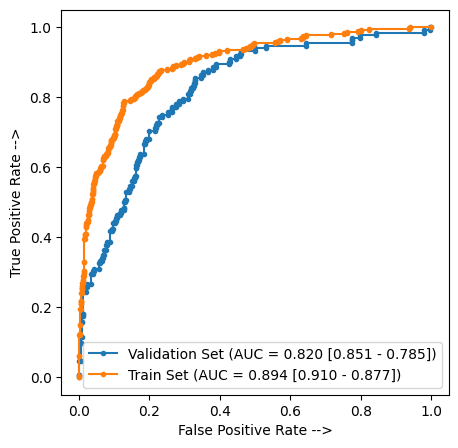

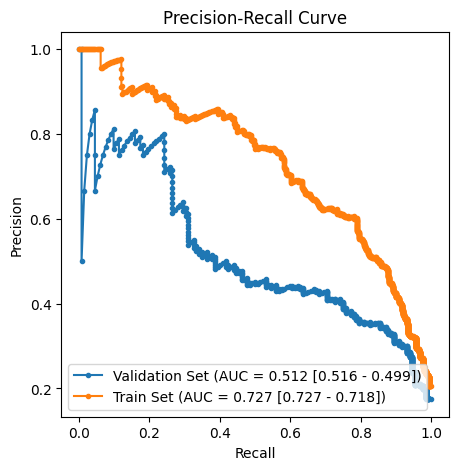

Youden cut-off =  0.22578378
BS train =  0.09563090756257447
BS validation =  0.11325461089673834
BSS train =  0.39491362966747245
BSS validation =  0.21660586944384996
F1 train =  0.6819338422391857
F1 validation =  0.5080385852090031
MCC train =  0.5996008270722493
MCC validation =  0.39073556865242076


In [14]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 30 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 30 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

print(train_patients)
display(train_patients)

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "2.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('2.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        32,"2.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 3 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
3,709422392096649,428124036471065,972433808768011,0,82.152104,0,0,0,1,1,...,9,4,8.92,8.22,7.87,5.42,11.10,14,0,0
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
13,228317629713460,811844987441852,770852312662831,0,59.609224,0,0,0,0,1,...,2,0,6.46,6.46,6.46,6.46,6.46,1,0,0
18,893924856245184,723038555585226,767890026091070,1,47.436636,0,0,0,0,1,...,2,0,6.68,6.81,6.55,6.55,6.81,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,3.651000e+03,3.651000e+03,3.651000e+03,3651.000000,3651.000000,3651.000000,3651.000000,3651.000000,3651.000000,3651.000000,...,3651.000000,3651.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3651.000000,3651.000000,3651.000000
mean,5.437077e+14,5.493461e+14,5.466388e+14,0.692961,64.218078,0.257738,0.033142,0.304300,0.064640,0.115859,...,2.988770,0.067105,8.330630,8.687900,7.995504,7.757377,9.020105,1.822788,0.517940,0.105724
std,2.606535e+14,2.596496e+14,2.642456e+14,0.461329,10.218880,0.437449,0.179031,0.460173,0.245923,0.320099,...,2.573018,0.398820,2.773738,3.762523,2.402191,2.323921,4.032600,2.166137,0.605358,0.307527
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,2.440000,2.440000,1.970000,2.440000,0.000000,0.000000,0.000000
25%,3.198630e+14,3.228981e+14,3.146123e+14,0.000000,57.964296,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.630000,6.600000,6.460000,6.275000,6.810000,1.000000,0.000000,0.000000
50%,5.376930e+14,5.430064e+14,5.419548e+14,1.000000,64.801043,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.930000,8.000000,7.700000,7.480000,8.210000,1.000000,0.000000,0.000000
75%,7.670773e+14,7.739194e+14,7.848606e+14,1.000000,71.424725,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.530000,9.845000,9.100000,8.890000,10.170000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,6.000000,86.980000,125.650000,62.330000,60.640000,125.650000,30.000000,15.000000,1.000000


Events in training dataset: 386
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,0
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.584000e+03,1.584000e+03,1.584000e+03,1584.000000,1584.000000,1584.000000,1584.00000,1584.000000,1584.000000,1584.000000,...,1584.000000,1584.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1584.000000,1584.000000,1584.000000
mean,5.447658e+14,5.517845e+14,5.522602e+14,0.727904,63.449258,0.258838,0.03346,0.296717,0.074495,0.108586,...,2.989268,0.064394,8.249896,8.580326,7.922657,7.661560,8.924034,1.866162,0.500000,0.099116
std,2.612086e+14,2.535960e+14,2.657724e+14,0.445180,10.588343,0.438135,0.17989,0.456955,0.262658,0.311217,...,2.673992,0.384007,2.480907,3.096249,2.327324,2.204741,3.426880,2.228232,0.621778,0.298912
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.152760e+14,3.420497e+14,3.126874e+14,0.000000,56.772263,0.000000,0.00000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.500000,6.467500,6.330000,6.150000,6.660000,1.000000,0.000000,0.000000
50%,5.427881e+14,5.531471e+14,5.609616e+14,1.000000,64.274650,0.000000,0.00000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.850000,7.960000,7.580000,7.425000,8.170000,1.000000,0.000000,0.000000
75%,7.750467e+14,7.740963e+14,7.935909e+14,1.000000,70.615522,1.000000,0.00000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.560000,9.852500,9.190000,8.932500,10.172500,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.00000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 157
Model saved to 3y_model.pkl
Confidence interval for the ML: [0.879 - 0.908]
Confidence interval for the ML: [0.795 - 0.859]


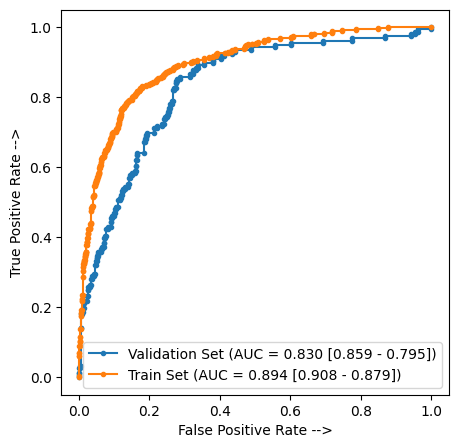

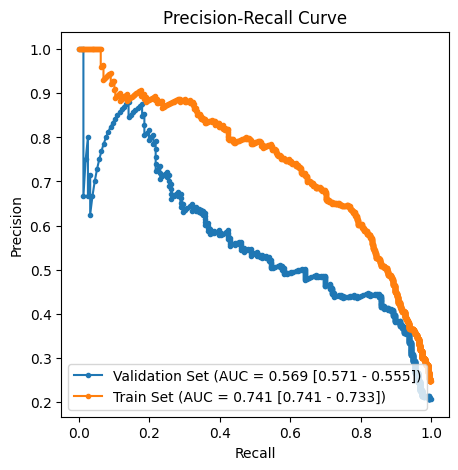

Youden cut-off =  0.2167236
BS train =  0.10341059932833317
BS validation =  0.12386703568799903
BSS train =  0.4050057228594234
BSS validation =  0.24586904567262968
F1 train =  0.6815761448349308
F1 validation =  0.5736842105263158
MCC train =  0.5846377644629386
MCC validation =  0.44866663386175015


In [15]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 3 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 3 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "3y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('3y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        36,"3y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 3.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
18,893924856245184,723038555585226,767890026091070,1,47.436636,0,0,0,0,1,...,2,0,6.68,6.81,6.55,6.55,6.81,2,1,0
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
36,212902005948701,605079604826919,755178991182496,1,65.170152,0,0,0,0,0,...,3,0,6.19,6.23,6.15,6.15,6.23,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,3.447000e+03,3.447000e+03,3.447000e+03,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,...,3447.000000,3447.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3447.000000,3447.000000,3447.000000
mean,5.439586e+14,5.479275e+14,5.448552e+14,0.694227,64.274542,0.259356,0.033943,0.304903,0.064984,0.117493,...,2.965477,0.062663,8.290163,8.619521,7.971982,7.737355,8.955446,1.802437,0.521903,0.125326
std,2.610473e+14,2.592034e+14,2.634487e+14,0.460801,10.147608,0.438345,0.181108,0.460433,0.246533,0.322054,...,2.591276,0.390865,2.446468,3.203773,2.230869,2.156942,3.539750,2.179979,0.609010,0.331137
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,2.440000,2.440000,1.970000,2.440000,0.000000,0.000000,0.000000
25%,3.203752e+14,3.226695e+14,3.146123e+14,0.000000,58.158616,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.610000,6.587500,6.450000,6.260000,6.780000,1.000000,0.000000,0.000000
50%,5.366440e+14,5.403220e+14,5.391453e+14,1.000000,64.839610,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.905000,7.960000,7.680000,7.470000,8.190000,1.000000,0.000000,0.000000
75%,7.667648e+14,7.727293e+14,7.810473e+14,1.000000,71.402991,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.500000,9.800000,9.100000,8.890000,10.100000,2.000000,1.000000,0.000000
max,9.996677e+14,9.999622e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,6.000000,23.510000,35.560000,23.510000,23.510000,44.790000,30.000000,15.000000,1.000000


Events in training dataset: 432
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.496000e+03,1.496000e+03,1.496000e+03,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,...,1496.000000,1496.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1496.000000,1496.000000,1496.000000
mean,5.430534e+14,5.509863e+14,5.542416e+14,0.726604,63.394623,0.259358,0.032086,0.298797,0.074198,0.110294,...,2.947861,0.058824,8.228658,8.552732,7.910284,7.648451,8.893956,1.848262,0.505348,0.120321
std,2.616359e+14,2.544507e+14,2.665398e+14,0.445851,10.612075,0.438429,0.176286,0.457884,0.262180,0.313361,...,2.675784,0.357269,2.489678,3.100875,2.343734,2.218091,3.431623,2.233308,0.627122,0.325445
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.780000,2.590000,1.860000,3.000000,0.000000,0.000000,0.000000
25%,3.127294e+14,3.412656e+14,3.175622e+14,0.000000,56.636264,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.492500,6.440000,6.330000,6.140000,6.652500,1.000000,0.000000,0.000000
50%,5.396286e+14,5.497154e+14,5.637709e+14,1.000000,64.187732,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.815000,7.910000,7.575000,7.410000,8.145000,1.000000,0.000000,0.000000
75%,7.752165e+14,7.745628e+14,7.947349e+14,1.000000,70.630653,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.507500,9.830000,9.150000,8.910000,10.127500,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,43.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,41.000000,12.000000,1.000000


Events in validation dataset: 180
Model saved to 3.5y_model.pkl
Confidence interval for the ML: [0.881 - 0.91]
Confidence interval for the ML: [0.799 - 0.86]


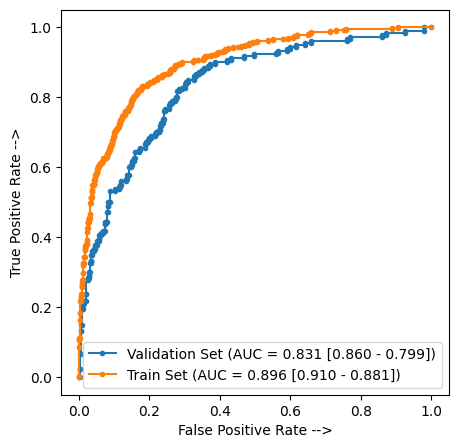

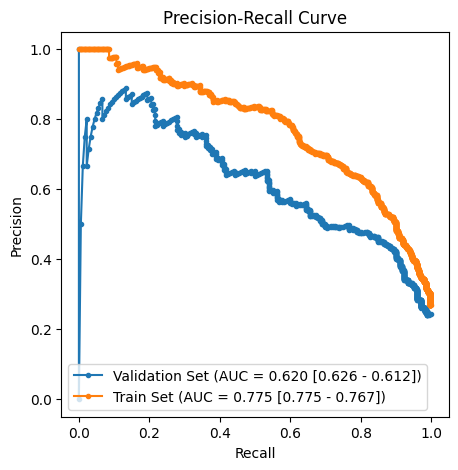

Youden cut-off =  0.2306499
BS train =  0.10915253969255492
BS validation =  0.13277224241150062
BSS train =  0.4178531216397071
BSS validation =  0.27008865234145285
F1 train =  0.7065868263473054
F1 validation =  0.5879518072289157
MCC train =  0.601198693530524
MCC validation =  0.44235556782327506


In [16]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 42 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 42 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "3.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('3.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        42,"3.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 4 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
9,729250457585405,270750133634068,460490849176471,1,62.110845,0,0,1,1,0,...,2,0,7.64,7.64,7.64,7.64,7.64,1,1,0
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
18,893924856245184,723038555585226,767890026091070,1,47.436636,0,0,0,0,1,...,2,0,6.68,6.81,6.55,6.55,6.81,2,1,0
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
36,212902005948701,605079604826919,755178991182496,1,65.170152,0,0,0,0,0,...,3,0,6.19,6.23,6.15,6.15,6.23,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,3.142000e+03,3.142000e+03,3.142000e+03,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,...,3142.000000,3142.000000,3017.000000,3017.000000,3017.00000,3017.000000,3017.000000,3142.000000,3142.000000,3142.000000
mean,5.445365e+14,5.481347e+14,5.438139e+14,0.693507,64.422894,0.268937,0.035646,0.310630,0.067155,0.117759,...,2.930936,0.059516,8.257189,8.567126,7.95057,7.728790,8.889732,1.780076,0.503819,0.149586
std,2.605094e+14,2.599636e+14,2.636239e+14,0.461110,10.141276,0.443478,0.185436,0.462825,0.250330,0.322374,...,2.567399,0.379291,2.436957,3.099119,2.23864,2.174875,3.409348,2.153533,0.613302,0.356722
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,2.440000,2.44000,1.970000,2.440000,0.000000,0.000000,0.000000
25%,3.224097e+14,3.233475e+14,3.152403e+14,0.000000,58.273496,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.580000,6.560000,6.43000,6.230000,6.760000,1.000000,0.000000,0.000000
50%,5.366275e+14,5.398089e+14,5.385260e+14,1.000000,65.026334,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.870000,7.930000,7.65000,7.460000,8.150000,1.000000,0.000000,0.000000
75%,7.672182e+14,7.750795e+14,7.791503e+14,1.000000,71.493022,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.490000,9.800000,9.06000,8.900000,10.080000,2.000000,1.000000,0.000000
max,9.996677e+14,9.994679e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,6.000000,23.510000,32.540000,23.51000,23.510000,42.600000,30.000000,15.000000,1.000000


Events in training dataset: 470
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
4,962864992156637,508024631968410,414721060707792,0,60.672380,0,0,0,0,0,...,3,0,5.81,5.81,5.81,5.81,5.81,1,0,0
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
14,100503397431899,513107127799164,611260394140654,0,49.332919,1,0,0,0,0,...,1,0,8.38,8.38,8.38,8.38,8.38,1,0,0
17,847826171621306,262738858231316,986748436761509,0,55.521543,0,0,0,0,0,...,2,0,6.93,6.93,6.93,6.93,6.93,1,1,0
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.373000e+03,1.373000e+03,1.373000e+03,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,...,1373.000000,1373.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1373.000000,1373.000000,1373.000000
mean,5.417346e+14,5.481946e+14,5.544224e+14,0.726147,63.300015,0.272396,0.033503,0.310269,0.072833,0.108521,...,2.898034,0.050255,8.218920,8.539252,7.910400,7.659796,8.845408,1.808449,0.493809,0.142753
std,2.621569e+14,2.536238e+14,2.662860e+14,0.446097,10.729712,0.445355,0.180012,0.462772,0.259957,0.311151,...,2.469600,0.321182,2.493325,3.076752,2.361398,2.226832,3.334604,2.004481,0.634984,0.349948
min,1.005034e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.870000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.117872e+14,3.390622e+14,3.165119e+14,0.000000,56.535535,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.487500,6.437500,6.320000,6.140000,6.640000,1.000000,0.000000,0.000000
50%,5.350884e+14,5.472140e+14,5.629044e+14,1.000000,64.077211,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.810000,7.905000,7.570000,7.405000,8.130000,1.000000,0.000000,0.000000
75%,7.761416e+14,7.675046e+14,7.950598e+14,1.000000,70.816374,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.490000,9.820000,9.157500,8.922500,10.100000,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,6.000000,25.130000,28.820000,27.950000,21.440000,36.680000,26.000000,12.000000,1.000000


Events in validation dataset: 196
Model saved to 4y_model.pkl
Confidence interval for the ML: [0.893 - 0.92]
Confidence interval for the ML: [0.802 - 0.859]


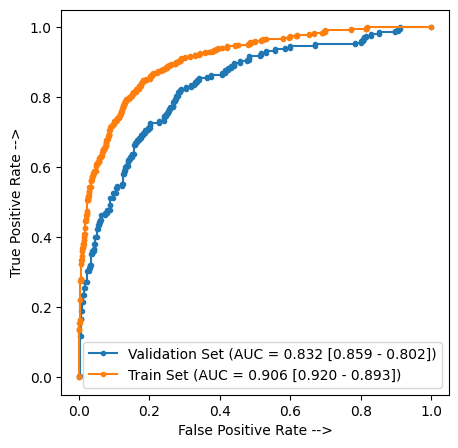

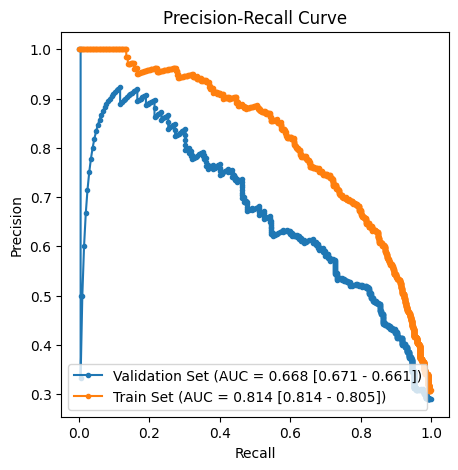

Youden cut-off =  0.23911616
BS train =  0.10712996792878464
BS validation =  0.14143657994404454
BSS train =  0.45232752970727963
BSS validation =  0.28613304470809386
F1 train =  0.7227356746765249
F1 validation =  0.6379310344827587
MCC train =  0.6144701074912413
MCC validation =  0.4866904798824367


In [17]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 4 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 4 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "4y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('4y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        48,"4y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 4.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
51,726520035699881,447354524497898,233324010495364,1,74.121429,0,0,0,0,0,...,4,1,6.71,6.87,6.62,6.26,7.10,4,1,1
55,348475512731423,855815012544028,644442901569428,0,64.679890,0,0,0,1,0,...,14,1,10.97,16.86,5.45,5.45,16.86,14,1,1
56,243247644504663,936853007312392,342043069084855,1,71.823389,0,0,0,0,0,...,3,0,11.09,9.84,12.34,9.84,12.34,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.772000e+03,2.772000e+03,2.772000e+03,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,...,2772.000000,2772.000000,2649.000000,2649.000000,2649.000000,2649.000000,2649.000000,2772.000000,2772.000000,2772.000000
mean,5.446638e+14,5.498250e+14,5.401000e+14,0.690115,64.566293,0.284271,0.037157,0.324675,0.069264,0.116883,...,2.928571,0.064214,8.274345,8.602103,7.959811,7.732699,8.926965,1.797619,0.487374,0.182900
std,2.604857e+14,2.598620e+14,2.624081e+14,0.462529,10.170574,0.451148,0.189181,0.468338,0.253948,0.321339,...,2.647310,0.399643,2.422039,3.124259,2.212623,2.145022,3.449356,2.239170,0.618656,0.386655
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,2.440000,2.440000,1.970000,2.440000,0.000000,0.000000,0.000000
25%,3.223949e+14,3.248405e+14,3.136031e+14,0.000000,58.285653,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.600000,6.570000,6.440000,6.250000,6.780000,1.000000,0.000000,0.000000
50%,5.373643e+14,5.447449e+14,5.319696e+14,1.000000,65.240804,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.900000,7.970000,7.680000,7.470000,8.170000,1.000000,0.000000,0.000000
75%,7.673873e+14,7.746512e+14,7.745391e+14,1.000000,71.665299,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.490000,9.800000,9.050000,8.900000,10.100000,2.000000,1.000000,0.000000
max,9.996677e+14,9.994679e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,6.000000,20.870000,32.540000,21.570000,20.870000,42.600000,30.000000,15.000000,1.000000


Events in training dataset: 507
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
53,880513362368818,503562019132777,346799182942183,1,81.324427,0,0,0,0,1,...,3,0,7.53,7.53,7.53,7.53,7.53,1,0,1
80,370831725805113,826262062378895,204466324419593,1,74.291986,0,0,0,1,0,...,5,0,10.76,13.52,7.31,7.31,14.51,6,1,1
99,843192543351224,275093810364981,691226485145124,0,66.579003,0,0,0,0,0,...,2,0,3.87,3.77,3.97,3.77,3.97,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.232000e+03,1.232000e+03,1.232000e+03,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,...,1232.000000,1232.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1232.000000,1232.000000,1232.000000
mean,5.451352e+14,5.476355e+14,5.493042e+14,0.724026,63.270831,0.280844,0.036526,0.318994,0.073864,0.108766,...,2.900974,0.047890,8.198062,8.521794,7.888812,7.639865,8.825889,1.817370,0.479708,0.174513
std,2.611563e+14,2.543465e+14,2.680810e+14,0.447185,10.751822,0.449594,0.187671,0.466276,0.261655,0.311472,...,2.545431,0.288099,2.519696,3.116800,2.374579,2.233829,3.392289,2.061584,0.639540,0.379704
min,1.008542e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.870000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.160586e+14,3.392602e+14,3.081253e+14,0.000000,56.535021,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.445000,6.425000,6.290000,6.130000,6.620000,1.000000,0.000000,0.000000
50%,5.427881e+14,5.467447e+14,5.474258e+14,1.000000,64.067754,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.790000,7.890000,7.550000,7.390000,8.110000,1.000000,0.000000,0.000000
75%,7.806279e+14,7.657474e+14,7.944964e+14,1.000000,70.809148,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.430000,9.725000,9.135000,8.915000,10.075000,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,4.000000,25.130000,28.820000,27.950000,21.440000,36.680000,26.000000,12.000000,1.000000


Events in validation dataset: 215
Model saved to 4.5y_model.pkl
Confidence interval for the ML: [0.900 - 0.927]
Confidence interval for the ML: [0.811 - 0.866]


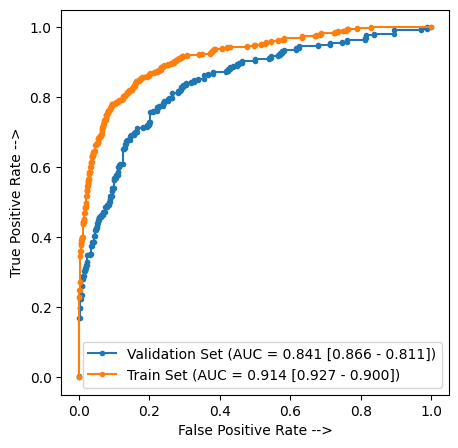

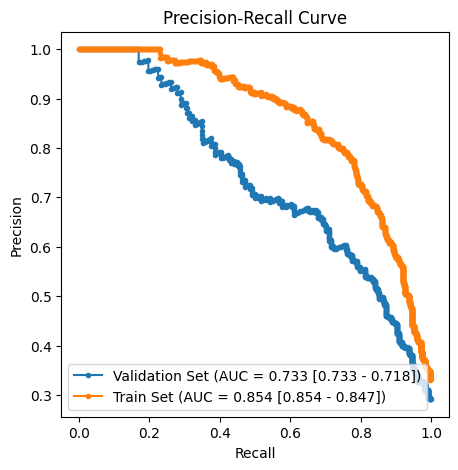

Youden cut-off =  0.35689405
BS train =  0.1049779894202495
BS validation =  0.13792722740881783
BSS train =  0.4918712444868596
BSS validation =  0.3294522911270993
F1 train =  0.7778874629812438
F1 validation =  0.6697459584295612
MCC train =  0.6858074781545518
MCC validation =  0.5365091013622308


In [18]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 54 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 54 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "4.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('4.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        54,"4.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
51,726520035699881,447354524497898,233324010495364,1,74.121429,0,0,0,0,0,...,4,1,6.71,6.87,6.62,6.26,7.10,4,1,1
55,348475512731423,855815012544028,644442901569428,0,64.679890,0,0,0,1,0,...,14,1,10.97,16.86,5.45,5.45,16.86,14,1,1
70,624238967610093,734628205934349,739246205604777,1,70.900202,0,0,0,0,0,...,1,0,10.34,10.34,10.34,10.34,10.34,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,513084819567745,345650065332204,121654706600649,1,66.450415,0,1,1,0,0,...,2,0,5.20,5.20,5.20,5.20,5.20,1,1,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.425000e+03,2.425000e+03,2.425000e+03,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,...,2425.000000,2425.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2425.000000,2425.000000,2425.000000
mean,5.461939e+14,5.508096e+14,5.394334e+14,0.693196,64.545749,0.300619,0.039588,0.336907,0.070103,0.114227,...,2.927835,0.070928,8.288281,8.624311,7.963633,7.743646,8.952505,1.818144,0.473402,0.220206
std,2.611976e+14,2.595925e+14,2.642219e+14,0.461262,10.137460,0.458622,0.195029,0.472750,0.255373,0.318152,...,2.710477,0.423037,2.411901,3.128580,2.181621,2.142192,3.469859,2.292260,0.620914,0.414471
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,2.440000,2.440000,1.970000,2.440000,0.000000,0.000000,0.000000
25%,3.242148e+14,3.270883e+14,3.112120e+14,0.000000,58.354798,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.620000,6.600000,6.450000,6.260000,6.830000,1.000000,0.000000,0.000000
50%,5.384082e+14,5.481883e+14,5.265315e+14,1.000000,65.164203,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.920000,7.990000,7.700000,7.480000,8.190000,1.000000,0.000000,0.000000
75%,7.724361e+14,7.746590e+14,7.792304e+14,1.000000,71.551570,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.505000,9.810000,9.055000,8.900000,10.100000,2.000000,1.000000,0.000000
max,9.996677e+14,9.994679e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,6.000000,20.870000,32.540000,20.870000,20.870000,42.600000,30.000000,15.000000,1.000000


Events in training dataset: 534
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
53,880513362368818,503562019132777,346799182942183,1,81.324427,0,0,0,0,1,...,3,0,7.53,7.53,7.53,7.53,7.53,1,0,1
80,370831725805113,826262062378895,204466324419593,1,74.291986,0,0,0,1,0,...,5,0,10.76,13.52,7.31,7.31,14.51,6,1,1
99,843192543351224,275093810364981,691226485145124,0,66.579003,0,0,0,0,0,...,2,0,3.87,3.77,3.97,3.77,3.97,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7429,358232821040625,191363045459141,218894185476209,1,69.415403,1,0,1,0,0,...,2,0,NaN,NaN,NaN,NaN,NaN,0,1,0
7433,419874218798918,164682534772558,640992460663549,1,52.469403,0,0,0,0,0,...,2,0,8.06,8.06,8.06,8.06,8.06,1,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.096000e+03,1.096000e+03,1.096000e+03,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,...,1096.000000,1096.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1096.000000,1096.000000,1096.000000
mean,5.445319e+14,5.499228e+14,5.433041e+14,0.721715,63.332840,0.290146,0.035584,0.332117,0.072993,0.114964,...,2.885036,0.052920,8.170104,8.516619,7.858873,7.605634,8.803826,1.831204,0.462591,0.210766
std,2.597226e+14,2.554686e+14,2.674599e+14,0.448359,10.901974,0.454037,0.185335,0.471188,0.260243,0.319124,...,2.585084,0.303602,2.486656,3.124328,2.373851,2.221473,3.313081,2.126109,0.651283,0.408039
min,1.008542e+14,1.011109e+14,1.001215e+14,0.000000,26.423573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.870000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.181322e+14,3.412656e+14,3.060501e+14,0.000000,56.504991,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.400000,6.400000,6.230000,6.070000,6.600000,1.000000,0.000000,0.000000
50%,5.396286e+14,5.486321e+14,5.327142e+14,1.000000,64.213414,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.780000,7.880000,7.545000,7.375000,8.080000,1.000000,0.000000,0.000000
75%,7.764967e+14,7.728405e+14,7.909545e+14,1.000000,71.203200,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.402500,9.700000,9.130000,8.892500,10.080000,2.000000,1.000000,0.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,4.000000,24.540000,23.800000,27.950000,19.050000,27.950000,26.000000,12.000000,1.000000


Events in validation dataset: 231
Model saved to 5y_model.pkl
Confidence interval for the ML: [0.906 - 0.932]
Confidence interval for the ML: [0.812 - 0.865]


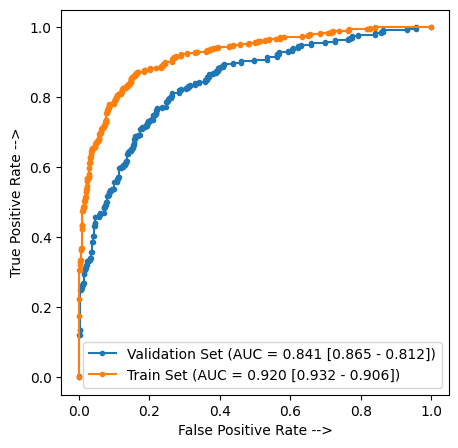

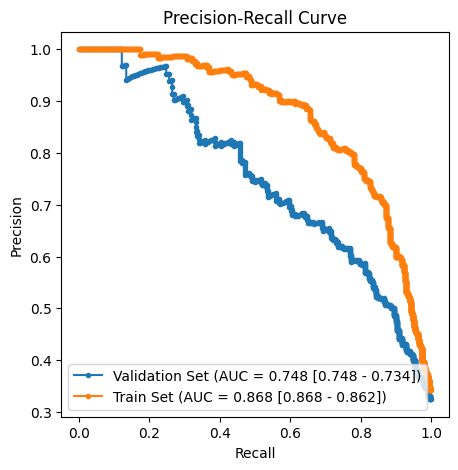

Youden cut-off =  0.30197522
BS train =  0.10492280173325846
BS validation =  0.14552774616370792
BSS train =  0.5050016712659089
BSS validation =  0.32678843253212164
F1 train =  0.7793103448275862
F1 validation =  0.6745562130177515
MCC train =  0.6755746505368766
MCC validation =  0.5124936508842179


In [19]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 5 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 5 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        60,"5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 5.5 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
51,726520035699881,447354524497898,233324010495364,1,74.121429,0,0,0,0,0,...,4,1,6.71,6.87,6.62,6.26,7.10,4,1,1
55,348475512731423,855815012544028,644442901569428,0,64.679890,0,0,0,1,0,...,14,1,10.97,16.86,5.45,5.45,16.86,14,1,1
70,624238967610093,734628205934349,739246205604777,1,70.900202,0,0,0,0,0,...,1,0,10.34,10.34,10.34,10.34,10.34,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,236200154705279,975682079550853,977484527323956,1,59.746187,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,2.049000e+03,2.049000e+03,2.049000e+03,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,...,2049.000000,2049.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,2049.000000,2049.000000,2049.000000
mean,5.462051e+14,5.524615e+14,5.385866e+14,0.695461,64.614854,0.310395,0.040508,0.346510,0.072230,0.122499,...,2.967301,0.080527,8.319867,8.680834,7.972123,7.736251,9.039918,1.883846,0.459736,0.271840
std,2.610252e+14,2.600389e+14,2.625545e+14,0.460324,10.143660,0.462768,0.197195,0.475974,0.258932,0.327941,...,2.840555,0.455925,2.431122,3.214029,2.174250,2.137316,3.586546,2.420045,0.548848,0.445016
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,2.440000,2.440000,1.970000,2.440000,0.000000,0.000000,0.000000
25%,3.251470e+14,3.269252e+14,3.152724e+14,0.000000,58.307686,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.630000,6.605000,6.460000,6.265000,6.840000,1.000000,0.000000,0.000000
50%,5.378980e+14,5.530376e+14,5.184383e+14,1.000000,65.031134,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.940000,8.030000,7.720000,7.480000,8.230000,1.000000,0.000000,0.000000
75%,7.694319e+14,7.803561e+14,7.723110e+14,1.000000,71.639606,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.550000,9.845000,9.060000,8.885000,10.170000,2.000000,1.000000,1.000000
max,9.996677e+14,9.994679e+14,9.994716e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,6.000000,20.870000,32.540000,20.870000,20.870000,42.600000,30.000000,4.000000,1.000000


Events in training dataset: 557
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
53,880513362368818,503562019132777,346799182942183,1,81.324427,0,0,0,0,1,...,3,0,7.53,7.53,7.53,7.53,7.53,1,0,1
80,370831725805113,826262062378895,204466324419593,1,74.291986,0,0,0,1,0,...,5,0,10.76,13.52,7.31,7.31,14.51,6,1,1
99,843192543351224,275093810364981,691226485145124,0,66.579003,0,0,0,0,0,...,2,0,3.87,3.77,3.97,3.77,3.97,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7420,561218996274667,399086079647637,417397079591851,1,41.179992,0,0,0,0,0,...,1,0,8.90,8.90,8.90,8.90,8.90,1,0,0
7423,632653329486333,664694231144080,564817824337315,1,72.056123,0,0,1,0,0,...,7,0,7.42,4.38,5.69,4.38,10.28,7,1,0
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,9.430000e+02,9.430000e+02,9.430000e+02,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,...,943.000000,943.000000,906.000000,906.000000,906.000000,906.000000,906.000000,943.000000,943.000000,943.000000
mean,5.428718e+14,5.468790e+14,5.373715e+14,0.716861,63.280800,0.301166,0.037116,0.342524,0.073171,0.112407,...,2.909862,0.059385,8.202152,8.564305,7.880861,7.616843,8.859923,1.869565,0.448568,0.257688
std,2.618933e+14,2.548017e+14,2.642990e+14,0.450762,10.987740,0.459008,0.189145,0.474806,0.260555,0.316034,...,2.692551,0.323651,2.496005,3.160652,2.381656,2.233556,3.348893,2.236770,0.668725,0.437593
min,1.008542e+14,1.011109e+14,1.004285e+14,0.000000,30.961136,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.870000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.145445e+14,3.397995e+14,3.027087e+14,0.000000,56.293475,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.415000,6.432500,6.255000,6.100000,6.620000,1.000000,0.000000,0.000000
50%,5.330539e+14,5.452200e+14,5.275834e+14,1.000000,64.001819,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.840000,7.950000,7.560000,7.405000,8.150000,1.000000,0.000000,0.000000
75%,7.779744e+14,7.667508e+14,7.807639e+14,1.000000,71.434009,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.487500,9.760000,9.187500,8.915000,10.100000,2.000000,1.000000,1.000000
max,9.997399e+14,9.987505e+14,9.997525e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,4.000000,24.540000,23.800000,27.950000,19.050000,27.950000,26.000000,12.000000,1.000000


Events in validation dataset: 243
Model saved to 5.5y_model.pkl
Confidence interval for the ML: [0.899 - 0.925]
Confidence interval for the ML: [0.802 - 0.854]


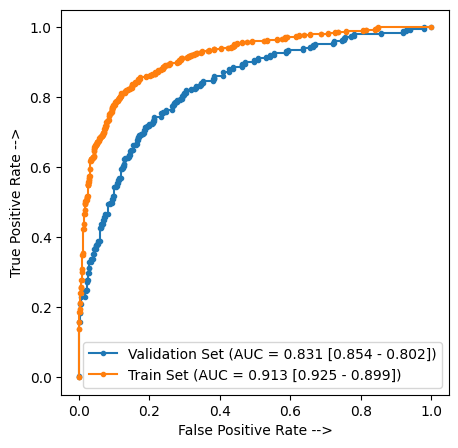

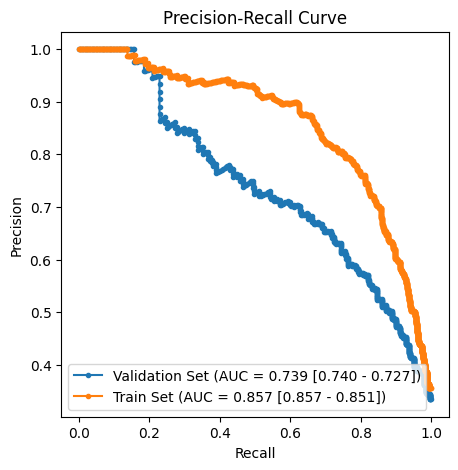

Youden cut-off =  0.3747388
BS train =  0.10873327127889298
BS validation =  0.15203243649185183
BSS train =  0.4993642387958651
BSS validation =  0.313095558561162
F1 train =  0.784899034240562
F1 validation =  0.6693548387096775
MCC train =  0.6801232206611102
MCC validation =  0.5069917013845994


In [20]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 66 months']
else:
    working_df['Outcome']=survival_df['Survival status CV 66 months']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "5.5y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('5.5y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        66,"5.5y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))



## Survival at 6 years

Training/testing dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
12,473954456018674,950098383910825,387700064820819,1,81.582167,1,0,1,0,0,...,5,0,10.54,10.54,10.54,10.54,10.54,1,1,1
29,344173114235509,497233800462359,611982194489506,1,61.966903,0,0,1,0,1,...,10,3,12.88,13.47,11.71,11.71,13.47,4,0,1
51,726520035699881,447354524497898,233324010495364,1,74.121429,0,0,0,0,0,...,4,1,6.71,6.87,6.62,6.26,7.10,4,1,1
55,348475512731423,855815012544028,644442901569428,0,64.679890,0,0,0,1,0,...,14,1,10.97,16.86,5.45,5.45,16.86,14,1,1
70,624238967610093,734628205934349,739246205604777,1,70.900202,0,0,0,0,0,...,1,0,10.34,10.34,10.34,10.34,10.34,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,236200154705279,975682079550853,977484527323956,1,59.746187,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0
7437,709952914258558,287416823993749,203293192306338,1,53.211969,0,0,1,0,0,...,2,0,6.98,6.98,6.98,6.98,6.98,1,1,0
7438,739081227574047,960929876644601,574694259499259,0,58.927116,0,0,1,0,0,...,2,0,4.24,4.24,4.24,4.24,4.24,1,1,0
7440,622884827571002,673552624015554,848435220082227,1,59.661416,0,0,0,0,0,...,2,1,5.45,4.99,5.53,4.99,5.82,3,1,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,1.686000e+03,1.686000e+03,1.686000e+03,1686.000000,1686.000000,1686.000000,1686.000000,1686.000000,1686.000000,1686.000000,...,1686.000000,1686.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1686.000000,1686.000000,1686.000000
mean,5.465041e+14,5.574618e+14,5.420011e+14,0.697509,64.867066,0.299526,0.041518,0.340451,0.072361,0.131079,...,3.034994,0.092527,8.364207,8.742565,8.002404,7.750229,9.128178,1.960261,0.467972,0.339858
std,2.595696e+14,2.618826e+14,2.614888e+14,0.459473,10.280443,0.458186,0.199545,0.474001,0.259161,0.337587,...,2.955148,0.496615,2.455270,3.265045,2.182424,2.140547,3.680249,2.492998,0.555400,0.473801
min,1.002216e+14,1.000910e+14,1.003432e+14,0.000000,21.276558,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.440000,2.440000,2.440000,1.970000,2.440000,0.000000,0.000000,0.000000
25%,3.295974e+14,3.303455e+14,3.246227e+14,0.000000,58.518082,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.670000,6.640000,6.522500,6.300000,6.920000,1.000000,0.000000,0.000000
50%,5.386571e+14,5.613812e+14,5.296423e+14,1.000000,65.454369,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.980000,8.070000,7.790000,7.540000,8.260000,1.000000,0.000000,0.000000
75%,7.659152e+14,7.934786e+14,7.745391e+14,1.000000,71.921711,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.607500,9.900000,9.117500,8.910000,10.257500,2.000000,1.000000,1.000000
max,9.995015e+14,9.994679e+14,9.984975e+14,1.000000,92.869150,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,6.000000,20.870000,32.540000,20.870000,20.870000,42.600000,30.000000,4.000000,1.000000


Events in training dataset: 573
Validation dataset


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
5,916435896905189,923921538756431,132498628731573,0,75.256225,0,0,0,0,1,...,5,0,8.93,11.71,6.80,6.80,11.71,3,0,1
21,142984713828507,744773184755790,447922639507924,1,62.792829,0,0,0,0,0,...,2,0,9.20,9.20,9.20,9.20,9.20,1,1,1
53,880513362368818,503562019132777,346799182942183,1,81.324427,0,0,0,0,1,...,3,0,7.53,7.53,7.53,7.53,7.53,1,0,1
80,370831725805113,826262062378895,204466324419593,1,74.291986,0,0,0,1,0,...,5,0,10.76,13.52,7.31,7.31,14.51,6,1,1
99,843192543351224,275093810364981,691226485145124,0,66.579003,0,0,0,0,0,...,2,0,3.87,3.77,3.97,3.77,3.97,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7420,561218996274667,399086079647637,417397079591851,1,41.179992,0,0,0,0,0,...,1,0,8.90,8.90,8.90,8.90,8.90,1,0,0
7423,632653329486333,664694231144080,564817824337315,1,72.056123,0,0,1,0,0,...,7,0,7.42,4.38,5.69,4.38,10.28,7,1,0
7424,687040412756305,183125890465521,662350154882356,0,64.061341,0,0,1,0,0,...,2,0,5.03,5.03,5.03,5.03,5.03,1,0,0
7425,323563846774071,173001468887147,485761994458738,1,59.850763,0,0,0,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0,0


,Nr. Ext.,Nr. Int.,CNP,Male sex,Age (years),History of MI,CABG,Previous PCI,Stroke/TIA,Atrial fibrillation,...,Urea (mg/dL) (Count),ESR (mm/h) (Count),WBC (10^3/uL) (Avg.),WBC (10^3/uL) (First),WBC (10^3/uL) (Last),WBC (10^3/uL) (Min.),WBC (10^3/uL) (Max.),WBC (10^3/uL) (Count),Uric acid (mg/dL) (Count),Outcome
count,7.950000e+02,7.950000e+02,7.950000e+02,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,...,795.000000,795.000000,764.000000,764.000000,764.000000,764.000000,764.000000,795.000000,795.000000,795.000000
mean,5.515237e+14,5.533918e+14,5.377030e+14,0.713208,63.417695,0.305660,0.040252,0.344654,0.071698,0.118239,...,2.984906,0.069182,8.200707,8.578901,7.875851,7.582474,8.904882,1.957233,0.455346,0.314465
std,2.620370e+14,2.526198e+14,2.642335e+14,0.452549,11.254389,0.460977,0.196672,0.475555,0.258150,0.323094,...,2.877389,0.349874,2.462172,3.138148,2.397207,2.209323,3.354675,2.398190,0.692861,0.464595
min,1.008542e+14,1.011109e+14,1.004285e+14,0.000000,30.961136,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.680000,2.920000,2.590000,1.860000,3.090000,0.000000,0.000000,0.000000
25%,3.237473e+14,3.462055e+14,3.054462e+14,0.000000,56.116350,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,6.400000,6.437500,6.250000,6.070000,6.615000,1.000000,0.000000,0.000000
50%,5.429609e+14,5.490014e+14,5.244386e+14,1.000000,64.127386,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,7.810000,7.935000,7.550000,7.330000,8.160000,1.000000,0.000000,0.000000
75%,7.824424e+14,7.737709e+14,7.849151e+14,1.000000,71.833268,1.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,0.000000,9.512500,9.792500,9.157500,8.882500,10.162500,2.000000,1.000000,1.000000
max,9.986089e+14,9.987505e+14,9.987299e+14,1.000000,91.993512,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,4.000000,24.540000,23.800000,27.950000,19.050000,27.950000,26.000000,12.000000,1.000000


Events in validation dataset: 250
Model saved to 6y_model.pkl
Confidence interval for the ML: [0.894 - 0.92]
Confidence interval for the ML: [0.805 - 0.857]


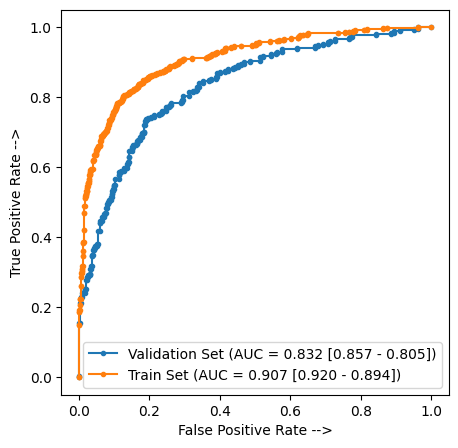

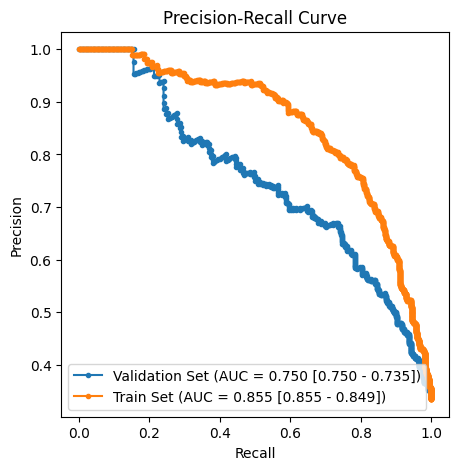

Youden cut-off =  0.37850752
BS train =  0.11272591101386782
BS validation =  0.1544560148512549
BSS train =  0.4877487019794198
BSS validation =  0.31424359466921004
F1 train =  0.7791095890410961
F1 validation =  0.6745562130177515
MCC train =  0.667332960395879
MCC validation =  0.509651956317508


In [21]:
working_df=clinical_df.copy()
if CV_death==0:
    working_df['Outcome']=survival_df['Survival status 6 years']
else:
    working_df['Outcome']=survival_df['Survival status CV 6 years']

unique_patients = working_df['CNP'].unique()
train_patients, validation_patients = train_test_split(unique_patients, test_size=0.3, random_state=12)
training_testing_df = working_df[working_df['CNP'].isin(train_patients)]
validation_df = working_df[working_df['CNP'].isin(validation_patients)]

training_testing_df.drop(training_testing_df[training_testing_df['Outcome'] <= -1].index, inplace = True)
validation_df.drop(validation_df[validation_df['Outcome'] <= -1].index, inplace = True)

print("Training/testing dataset")
display(training_testing_df)
display(training_testing_df.describe(include='all'))
print('Events in training dataset:' ,training_testing_df['Outcome'].sum())

print("Validation dataset")
display(validation_df)
display(validation_df.describe(include='all'))
print('Events in validation dataset:' ,validation_df['Outcome'].sum())

model=train_model_with_bayesian_search(training_testing_df,best_params)
save_model(model, "6y_model.pkl")

X_train = training_testing_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_train = training_testing_df['Outcome']

predictions_train=model.predict_proba(X_train)[:, 1]

X_validation = validation_df.drop(columns=['Outcome','CNP','Nr. Int.','Nr. Ext.'])
y_validation = validation_df['Outcome']

predictions_validation=model.predict_proba(X_validation)[:, 1]

preds=np.concatenate([predictions_train, predictions_validation])

validation_df['Validation set'] = 1
training_testing_df['Validation set'] = 0 
merged_df = pd.concat([training_testing_df, validation_df]) 
preds_df = pd.DataFrame(preds)
merged_df=pd.concat([merged_df.reset_index(drop=True), preds_df.reset_index(drop=True),], axis=1)
merged_df=merged_df.rename(columns={0: "Probabilities"})
merged_df.to_csv('6y_trainingtesting_validation_dataframe.csv', sep=',',decimal='.',index=False)

validation_fpr, validation_tpr, thresholds_roc_validation = roc_curve(y_validation,predictions_validation)
auc_roc_validation = auc(validation_fpr, validation_tpr)

train_fpr, train_tpr, thresholds_roc_train = roc_curve(y_train,predictions_train)
auc_roc_train = auc(train_fpr, train_tpr)

upper_roc_train,lower_roc_train = compute_bootstrapped_AUC_ROC_CI(y_train,predictions_train)
upper_roc_validation,lower_roc_validation = compute_bootstrapped_AUC_ROC_CI(y_validation,predictions_validation)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(validation_fpr, validation_tpr, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_validation, lower_roc_validation, upper_roc_validation))
plt.plot(train_fpr, train_tpr, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_roc_train, lower_roc_train, upper_roc_train))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,predictions_train)
auc_pr_train = auc(recall_train, precision_train)

precision_validation, recall_validation, thresholds_validation = precision_recall_curve(y_validation,predictions_validation)
auc_pr_validation = auc(recall_validation, precision_validation)

upper_pr_train,lower_pr_train = compute_bootstrapped_AUC_PR_CI(precision_train, recall_train)
upper_pr_validation,lower_pr_validation = compute_bootstrapped_AUC_PR_CI(precision_validation, recall_validation)

plt.figure(figsize=(5, 5), dpi=100)    
plt.plot(recall_validation, precision_validation, marker='.', label='Validation Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_validation, lower_pr_validation, upper_pr_validation))
plt.plot(recall_train, precision_train, marker='.', label='Train Set (AUC = %0.3f [%.3f - %.3f])' % (auc_pr_train, lower_pr_train, upper_pr_train))

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left')
plt.show()

youden=calculate_youden_cutoff(train_tpr, train_fpr, thresholds_roc_train)
print("Youden cut-off = ",youden)
print("BS train = ",brier_score_loss(y_train,predictions_train))
print("BS validation = ",brier_score_loss(y_validation,predictions_validation))
print("BSS train = ",brier_skill_score(y_train,predictions_train))
print("BSS validation = ",brier_skill_score(y_validation,predictions_validation))

binary_predictions_train = [1 if elem >= youden else 0 for elem in predictions_train]
binary_predictions_validation = [1 if elem >= youden else 0 for elem in predictions_validation]

print("F1 train = ", f1_score(y_train,binary_predictions_train))
print("F1 validation = ", f1_score(y_validation,binary_predictions_validation))
print("MCC train = ", matthews_corrcoef(y_train,binary_predictions_train))
print("MCC validation = ", matthews_corrcoef(y_validation,binary_predictions_validation))

No_total_hospitalizations=merged_df['Outcome'].count()
No_unique_patients=len(training_testing_df['CNP'].unique())+len(validation_df['CNP'].unique())
No_total_events=merged_df['Outcome'].sum()
No_training_events=y_train.sum()
No_training_patients=len(training_testing_df['CNP'].unique())
No_training_hospitalizations=y_train.count()
No_validation_patients=len(validation_df['CNP'].unique())
No_validation_events=y_validation.sum()
No_validation_hospitalizations=y_validation.count()

append_result_to_csv(No_total_hospitalizations, No_unique_patients, No_total_events,
                     No_training_events, No_training_patients, No_training_hospitalizations,
                        No_validation_patients, No_validation_events, No_validation_hospitalizations,
                        72,"6y", auc_roc_train,lower_roc_train, upper_roc_train, auc_roc_validation, lower_roc_validation, upper_roc_validation, 
                        auc_pr_train, lower_pr_train, upper_pr_train, auc_pr_validation, lower_pr_validation, upper_pr_validation, youden, 
                        matthews_corrcoef(y_train,binary_predictions_train), matthews_corrcoef(y_validation,binary_predictions_validation),
                        f1_score(y_train,binary_predictions_train), f1_score(y_validation,binary_predictions_validation),
                        brier_score_loss(y_train,predictions_train), brier_score_loss(y_validation,predictions_validation),
                        brier_skill_score(y_train,predictions_train), brier_skill_score(y_validation,predictions_validation))

